In [25]:
import pandas as pd

In [26]:
data = pd.read_csv("WA_Marketing-Campaign.csv")

In [27]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [28]:
data.isna().any()

MarketID            False
MarketSize          False
LocationID          False
AgeOfStore          False
Promotion           False
week                False
SalesInThousands    False
dtype: bool

Perfect all good!

## Visulizations 

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

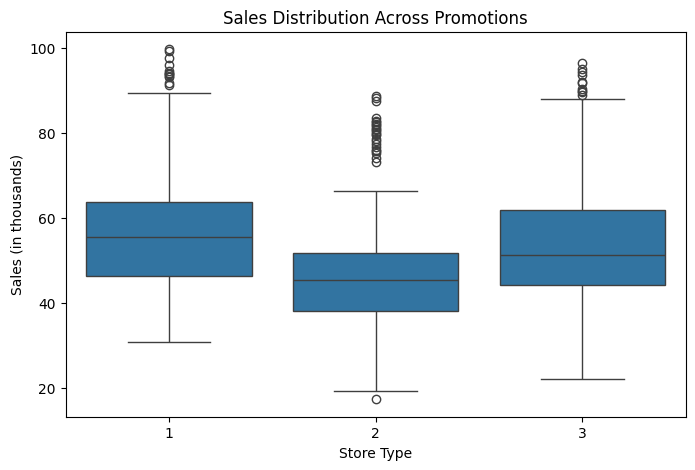

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promotion", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Promotions")
plt.xlabel("Store Type")
plt.ylabel("Sales (in thousands)")

plt.show()


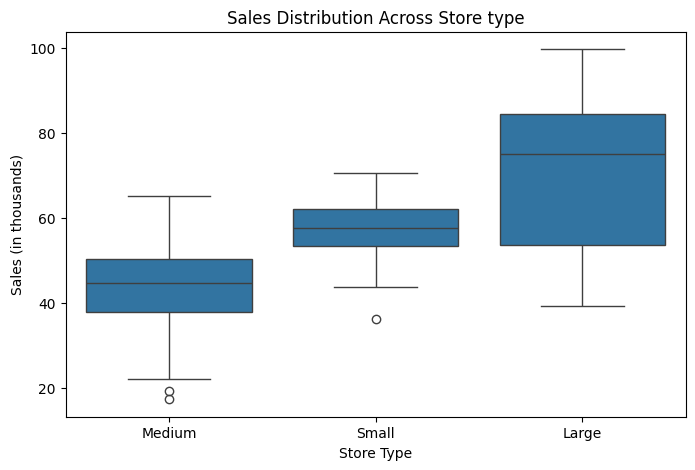

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="MarketSize", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Store type")
plt.xlabel("Store Type")
plt.ylabel("Sales (in thousands)")

plt.show()


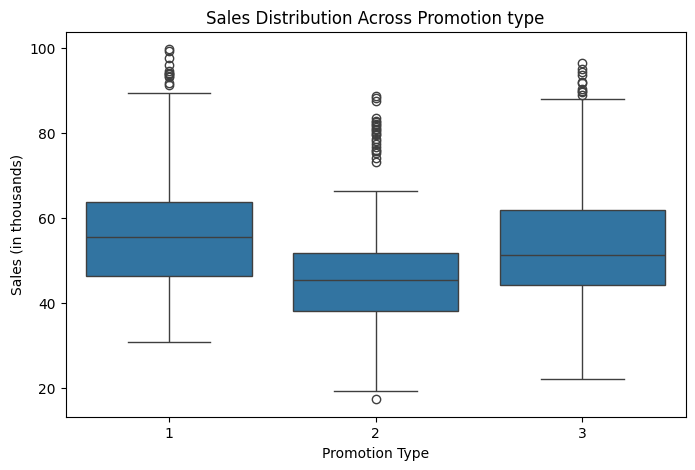

In [32]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promotion", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Promotion type")
plt.xlabel("Promotion Type")
plt.ylabel("Sales (in thousands)")

plt.show()

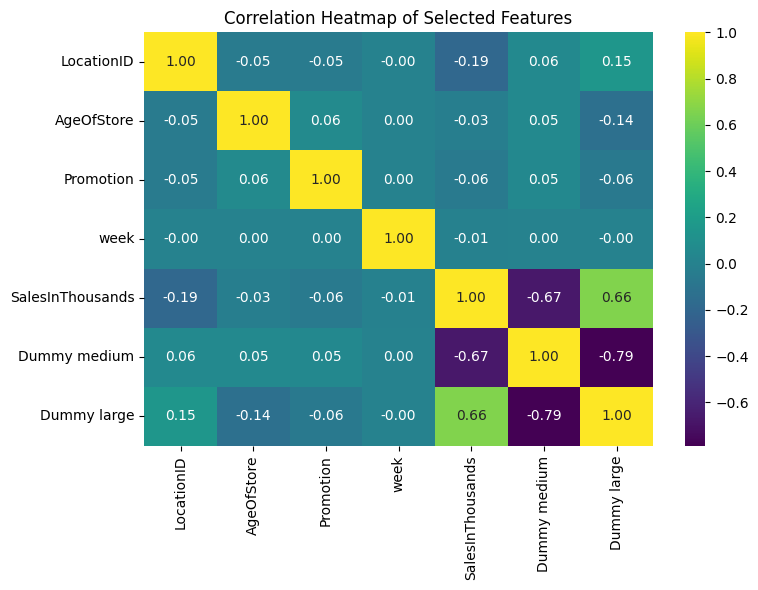

In [33]:
data["Dummy medium"] = (data["MarketSize"] == "Medium").astype(int)
data["Dummy large"] = (data["MarketSize"] == "Large").astype(int)

plt.figure(figsize=(8, 6))

sns.heatmap(data.iloc[:, 2:].corr(), annot=True, fmt=".2f", cmap="viridis")
# Title
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

I think the obvious takeaway here is that. Both Medium and Large have an impact on SalesInThousands so let's make sure we take that into account during our AB testing

In [34]:
data["Promotion"].value_counts()

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [35]:
data["MarketSize"].value_counts()

MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

In [36]:
data.groupby("MarketSize")["Promotion"].value_counts()

MarketSize  Promotion
Large       2             64
            1             56
            3             48
Medium      3            116
            2            108
            1             96
Small       3             24
            1             20
            2             16
Name: count, dtype: int64

Seems Balanced!

## Statistics
Before we can fully get started we need to a hypothesis

Null hypothesis $H_0$ = all promotions are the same

Alternativ hypothesis $H_A$ = Some promotions are better

In [37]:
from scipy import stats
from scipy.stats import mannwhitneyu

sales_promo1 = data[data["Promotion"] == 1]["SalesInThousands"]
sales_promo2 = data[data["Promotion"] == 2]["SalesInThousands"]
sales_promo3 = data[data["Promotion"] == 3]["SalesInThousands"]

In [38]:
def ttest(data: list):
    assert len(data) == 3 # if wrong length

    dictionary = {}
    for i in range(len(data) - 1):
        for j in range(i + 1, len(data)):
        
            U1, p_value = stats.ttest_ind(data[i], data[j])
            key = f"Promo{i+1} vs Promo{j+1}"  # create key
            dictionary[key] = p_value  # Store p-value in the dictionary
    return dictionary
    
biglist = (sales_promo1, sales_promo2, sales_promo3)
results_ttest = ttest(biglist)

In [39]:
results_ttest

{'Promo1 vs Promo2': 3.5506696512134566e-10,
 'Promo1 vs Promo3': 0.12079667272313273,
 'Promo2 vs Promo3': 1.562894303627738e-06}

In [40]:
def MannwhitneyU(data: list) -> dict:
    assert len(data) == 3 # if wrong length

    dictionary = {}
    for i in range(len(data) - 1):
        for j in range(i + 1, len(data)):
        
            U1, p_value = mannwhitneyu(data[i], data[j])
            key = f"Promo{i+1} vs Promo{j+1}"  # create key
            dictionary[key] = p_value  # Store p-value in the dictionary

    return dictionary

biglist = (sales_promo1, sales_promo2, sales_promo3)
results_MannwhitneyU = MannwhitneyU(biglist)

In [41]:
results_MannwhitneyU

{'Promo1 vs Promo2': 5.845935246838518e-12,
 'Promo1 vs Promo3': 0.035084095693231204,
 'Promo2 vs Promo3': 1.1970084441651803e-07}

With the t-test we can not reject the null hypthesis that the difference between Promo1 and Promo 3

With the MannwhitneyU non-parametric test we can reject the null hypothesis

Slight issue here is that this is the birdseye view, instead let's delve into the details and see if the results are any different for store sizes

In [42]:
df_small = data[data["MarketSize"] == "Small"]
df_medium = data[data["MarketSize"] == "Medium"]
df_large = data[data["MarketSize"] == "Large"]

In [43]:
def create_dataframe(dataframe):
    """Create a dataframe"""
    dataframe1 = dataframe[dataframe["Promotion"] == 1]["SalesInThousands"]
    dataframe2 = dataframe[dataframe["Promotion"] == 2]["SalesInThousands"]
    dataframe3 = dataframe[dataframe["Promotion"] == 3]["SalesInThousands"]

    return dataframe1, dataframe2, dataframe3

# Turn them into dataframes
df_small1, df_small2, df_small3 = create_dataframe(df_small)
df_medium1, df_medium2, df_medium3 = create_dataframe(df_medium)
df_large1, df_large2, df_large3 = create_dataframe(df_large)

# Turn them into lists
list_small = (df_small1, df_small2, df_small3)
list_medium = (df_medium1, df_medium2, df_medium3)
list_large = (df_large1, df_large2, df_large3)

In [44]:
results_small1 = MannwhitneyU(list_small)
results_small2 = ttest(list_small)

results_small1, results_small2

({'Promo1 vs Promo2': 4.927166796986004e-05,
  'Promo1 vs Promo3': 0.7954179576841569,
  'Promo2 vs Promo3': 5.8957036810791074e-05},
 {'Promo1 vs Promo2': 1.275311840977098e-05,
  'Promo1 vs Promo3': 0.6810867067433423,
  'Promo2 vs Promo3': 1.7059958706547655e-05})

We cannot reject the null hypothesis between Promotion for Small stores.

In [45]:
results_medium = MannwhitneyU(list_medium)
results_medium1 = ttest(list_medium)

results_medium, results_medium1

({'Promo1 vs Promo2': 6.694419331697923e-10,
  'Promo1 vs Promo3': 0.10559079188934165,
  'Promo2 vs Promo3': 1.21452083281794e-07},
 {'Promo1 vs Promo2': 1.1261780419231887e-11,
  'Promo1 vs Promo3': 0.04939721833170492,
  'Promo2 vs Promo3': 5.470518861290425e-08})

We cannot reject the null hypothesis between Promotion for medium stores using the t-test, but we can reject it using the Mann-Whitney U test.

In [46]:
results_large = MannwhitneyU(list_large)
results_large1 = ttest(list_large)

results_large, results_large1

({'Promo1 vs Promo2': 1.611787855020616e-07,
  'Promo1 vs Promo3': 0.9765916069490451,
  'Promo2 vs Promo3': 1.496399158780798e-08},
 {'Promo1 vs Promo2': 7.854262204192481e-07,
  'Promo1 vs Promo3': 0.5063120169025387,
  'Promo2 vs Promo3': 5.727627382209345e-08})

We cannot reject the null hypothesis between Promotion for Large stores using the  Mann-Whitney U test , but we can reject it using the t-test.

Lets try something else. 

# Bayesian Statitics!

$$
P(A|B) = \frac{P(A|B)P(A)}{P(B)}
$$

In [49]:
import pymc as pm
import numpy as np

In [79]:
# Function to create a simple Bayesian model with one value per dataset
def simple_bayesian_estimate(data):
    assert len(data) == 3

    with pm.Model() as model:
        # Priors for the means of the promotions (normal priors with wide variance)
        mu_A = pm.Normal('mu_A', mu=data[0].mean(), sigma=data[0].std())
        mu_B = pm.Normal('mu_B', mu=data[1].mean(), sigma=data[1].std())
        mu_C = pm.Normal('mu_C', mu=data[2].mean(), sigma=data[2].std())
        
        # Priors for the standard deviations of the promotions
        sigma_A = pm.HalfNormal('sigma_A', sigma=data[0])
        sigma_B = pm.HalfNormal('sigma_B', sigma=data[1])
        sigma_C = pm.HalfNormal('sigma_C', sigma=data[2])
        
        # Likelihood for each promotion
        likelihood_A = pm.Normal('likelihood_A', mu=mu_A, sigma=sigma_A, observed=data[0])
        likelihood_B = pm.Normal('likelihood_B', mu=mu_B, sigma=sigma_B, observed=data[1])
        likelihood_C = pm.Normal('likelihood_C', mu=mu_C, sigma=sigma_C, observed=data[2 ])
        
        # Sample from the posterior
        trace = pm.sample(2000, return_inferencedata=False)

        return trace
    

def differences_in_mu(trace):
    diff_AB = trace['mu_B'] - trace['mu_A']
    diff_AC = trace['mu_C'] - trace['mu_A']
    diff_BC = trace['mu_C'] - trace['mu_B']
    return diff_AB, diff_AC, diff_BC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, mu_C, sigma_A, sigma_B, sigma_C]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
There were 1925 divergences after tuning. Increase `target_accept` or reparameterize.


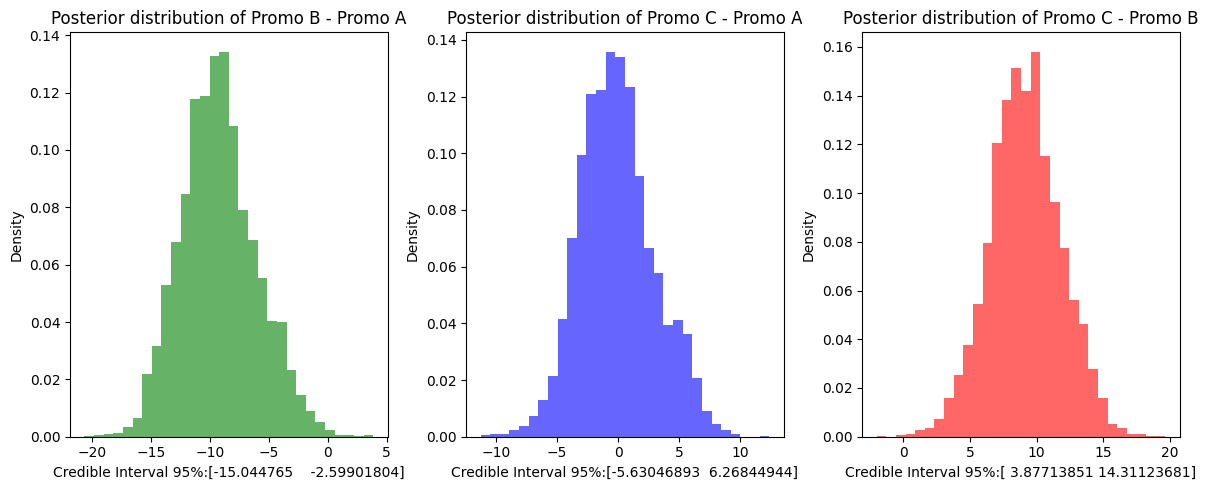

In [80]:
trace = simple_bayesian_estimate(list_small)
diff_AB, diff_AC, diff_BC = differences_in_mu(trace)

def plots(diff_AB, diff_AC, diff_BC ):
    """Plots a beautiful graph"""
    plt.figure(figsize=(12, 5))

    credible_interval_AB = np.percentile(diff_AB, [2.5, 97.5])
    credible_interval_AC= np.percentile(diff_AC, [2.5, 97.5])
    credible_interval_BC= np.percentile(diff_BC, [2.5, 97.5])

    plt.subplot(1, 3, 1)
    plt.hist(diff_AB, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Posterior distribution of Promo B - Promo A')
    plt.xlabel(f"Credible Interval 95%:{credible_interval_AB}")
    plt.ylabel('Density')

    plt.subplot(1, 3, 2)
    plt.hist(diff_AC, bins=30, density=True, alpha=0.6, color='b')
    plt.title('Posterior distribution of Promo C - Promo A')
    plt.xlabel(f"Credible Interval 95%:{credible_interval_AC}")
    plt.ylabel('Density')

    plt.subplot(1, 3, 3)
    plt.hist(diff_BC, bins=30, density=True, alpha=0.6, color='r')
    plt.title('Posterior distribution of Promo C - Promo B')
    plt.xlabel(f"Credible Interval 95%:{credible_interval_BC}")
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    
plots(diff_AB, diff_AC, diff_BC)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, mu_C, sigma_A, sigma_B, sigma_C]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2859 divergences after tuning. Increase `target_accept` or reparameterize.


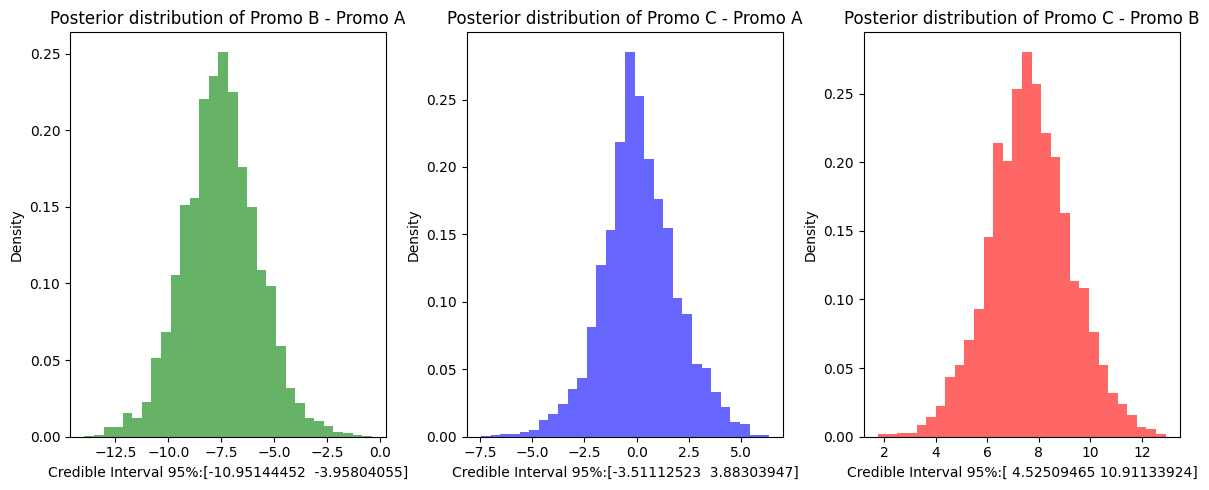

In [81]:
trace = simple_bayesian_estimate(list_medium)
diff_AB, diff_AC, diff_BC = differences_in_mu(trace)

plots(diff_AB, diff_AC, diff_BC)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, mu_C, sigma_A, sigma_B, sigma_C]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3178 divergences after tuning. Increase `target_accept` or reparameterize.


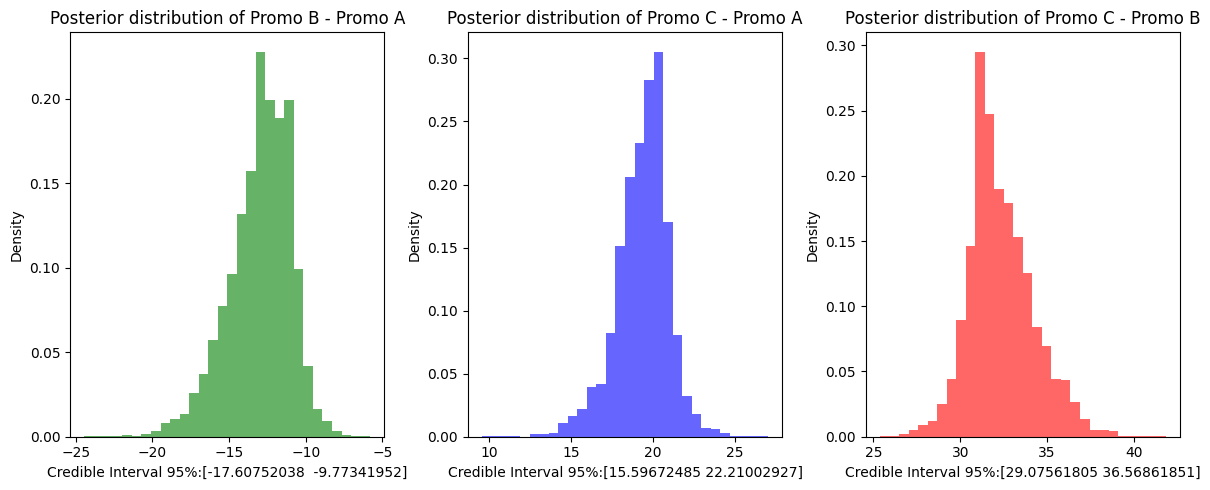

In [82]:
trace = simple_bayesian_estimate(list_large)
diff_AB, diff_AC, diff_BC = differences_in_mu(trace)

plots(diff_AB, diff_AC, diff_BC)

These results are certainly intriguing. By employing traditional T-tests, non-parametric tests, and Bayesian statistics, we consistently observe a significant difference when comparing Promotion 1 to Promotion 2, and similarly, when comparing Promotion 2 to Promotion 3. However, the situation becomes more complex when we attempt to compare the outcomes of Promotion 1 and Promotion 3. The results are inconsistent—sometimes a clear effect is evident, while other times, we find ourselves on the cusp of either rejecting or retaining the null hypothesis.

From a business perspective, if I were to analyze these results, I would firmly conclude that Promotion 2 is, without a doubt, ineffective. However, drawing definitive conclusions from Promotions 1 or 3 is more challenging. Statistically, it’s unlikely that one of these promotions is consistently better than the other, so I would advise caution before making any strong assertions about their relative effectiveness.